In [181]:
from __future__ import print_function

import os
import sys
import time

import torch
print(torch.__version__)
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import numpy as np
from math import floor

from sklearn.model_selection import KFold
import pandas as pd

from bayes_opt import BayesianOptimization

#import scripts
import importlib as importlib
sys.path.append(os.path.abspath('./helper_functions'))
import helper_functions.compute_stats as compute_stats
import helper_functions.generate_images as generate_images
import helper_functions.helper_functions as helper_functions
import helper_functions.import_data as import_data
import helper_functions.plot_data as plot_data
import helper_functions.load_data as load_data

#set gpu env
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device",device)
print("cuda version",torch.version.cuda)


2.3.0+cu121
Device cuda:0
cuda version 12.1


Init Financial Data

In [182]:
class Parameters:
    def __init__(self):
        self.scenario = 0

        # Stock tickers
        self.train_stock_ticker = 'SIVBQ'
        self.test_stock_ticker = 'SICP'
        #self.test_stock_ticker = 'MSFT'
        self.index_ticker = '^SP500-40'
        
        # Close price time period
        self.start_date = '2021-12-05'
        self.end_date = '2023-01-25'

        # Time series to image transformation algorithm: GRAMIAN 1; MARKOV 2
        self.transform_algo_type = 1
        self.transform_algo = generate_images.TransformAlgo.from_value(self.transform_algo_type)
        self.image_resolution_x = 32
        self.image_resolution_y = 32
        
        # GAF image inputs
        self.gaf_method = "summation"
        self.transformed_img_sz = 32
        self.sample_range = (0, 1)
        
        # GRAMIAN/MARKOV: image transformation scale
        # self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.scaler = StandardScaler()

        # Training's test size
        self.training_test_size = 0.5
        self.external_test_size = 1

        self.model_name ='LeNet-5 Based Net'
        # Default hyperparameters
        self.filter_size_1 = (2, 3)
        self.filter_size_2 = (2, 2)
        self.filter_size_3 = (2, 3)

        self.stride_1 = 1
        self.stride_2 = 2

        self.output_conv_1 = 40
        self.output_conv_2 = 12
        self.output_FC_1 = 100
        self.output_FC_2 = 70
        self.final_FCLayer_outputs = 1

        self.learning_rate = 0.00001
        self.momentum = 0.9

        self.dropout_probab = 0

        self.batch_size = 16

        self.num_epochs_input = 10000

        self.loss_threshold = 0.0001

        self.epoch_running_loss_check = 500
        
        self.epoch_running_gradients_check = 4000

        self.transform = generate_images.SetTransform(normalize_ftor=0.5, resolution_x=32, resolution_y=32)


Init Hyper-parameters

## Import Financial Data Functions

In [183]:
def import_stock_data(stock_ticker, start_date, end_date):
    #import stock dataset
    stock_dataset_df = import_data.import_dataset(stock_ticker, start_date, end_date)
    stock_dataset_df.head()

    return stock_dataset_df

In [184]:
# Graph to compare rebased prices with the S&P Financials index
def plot_price_comparison_stocks(index_ticker,train_stock_ticker,stock_dataset_df, start_date, end_date):
    plot_data.compare_stocks(index_ticker,train_stock_ticker,stock_dataset_df, start_date, end_date)

## Image Transformation Functions

In [185]:
def transform_timeseries_to_images(stock_dataset_df, transformed_img_sz, transform_algo, gaf_method):
    full_feature_data = np.array(stock_dataset_df['Close'])
    print(len(stock_dataset_df['Close']))
    #print("feature_dataset_array",feature_data)

    print("len datapoints in dataset",len(full_feature_data), "images generated", int(len(full_feature_data)/transformed_img_sz))

    np.set_printoptions(threshold=np.inf)
    transformed_images = generate_images.generate_transformed_images(full_feature_data, transform_algo, gaf_img_sz=transformed_img_sz, method=gaf_method)

    print("transformed_images.shape",transformed_images.shape)
    #plt.imshow(gaf_images[0],cmap='hot')
    #print("gaf_images.shape",gaf_images.shape,"data points in images",gaf_images.size, "gaf image [0] shape",gaf_images[0].shape, "data points in image [0]",gaf_images[0].size)
    #print("gasf image[0] data",gaf_images[0])
    #print("Gasf data",gasf_images)

    return transformed_images

In [186]:
def generate_features_lists(stock_dataset_df, transform_algo, transformed_img_sz, gaf_method, sample_range):
    #Generate images from dataset
    cols_used = ["Open", "High", "Low", "Close"]
    cols_used_count = sum(column_name in cols_used for column_name in stock_dataset_df.columns)
    feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_images.generate_multiple_feature_images(stock_dataset_df, cols_used, transform_algo, image_size=transformed_img_sz, method=gaf_method, sample_range=sample_range)
    #print("image data",feature_image_dataset_list,"labels",feature_label_dataset_list)
    print("shape [0] set",np.array(feature_image_dataset_list[0]).shape)

    #np.set_printoptions()

    return feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list, cols_used_count, cols_used

In [187]:
def squeeze_array(images_array, labels_array):
    #squeeze arrays
    images_array = images_array.squeeze(axis=(0, 1))
    print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
    print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

    return images_array, labels_array

In [188]:
def Generate_feature_image_to_f32(labels_array, images_array, transformed_img_sz, scaler):
    feature_image_dataset_list_f32, labels_scaled_list_f32 = generate_images.Generate_feature_image_dataset_list_f32(labels_array, images_array, transformed_img_sz, scaler)
    return feature_image_dataset_list_f32, labels_scaled_list_f32

In [189]:
#create array of images
def create_images_array(feature_image_dataset_list, feature_label_dataset_list):
    images_array = helper_functions.data_to_array(feature_image_dataset_list)
    labels_array = helper_functions.data_to_array(feature_label_dataset_list)
    # images_array=np.array(feature_image_dataset_list)
    # labels_array=np.array(feature_label_dataset_list)
    #print("len price array",len(prices_array),prices_array.shape,prices_array)
    #print("images_array",len(images_array[0][0][0]),"labels_array",len(labels_array[0]),"prices array",len(prices_array[0][0]))
    #print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
    #print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

    return images_array, labels_array

# Visualize Image Functions

In [190]:
def quick_view_images(images_array, cols_used_count, cols_used):
    
    # Plot the first image of each column
    fig, axes = plt.subplots(nrows=1, ncols=cols_used_count, figsize=(20, 6))
    for ax in axes:
        ax.set_aspect('equal')

    #EXPLANATION SHAPE
    #shape images array (1, 1, 4, 480(=15 chunks * 32 windows), 32, 32)
    #I get 15 images (32x32) for 491 data points (491 = 524 - 33 data points for sliding windows, i.e. 32+1 for label)
    #I create 32*15=480 32x32images
    #print("image",images_array[0])
    print("shape images array",images_array.shape,"shape image",images_array[0][0][0][0].shape)
    for i in range(cols_used_count):
        axes[i].imshow(images_array[0][0][i][0], cmap='hot')
        axes[i].set_title(f"Column {cols_used[i]} ")

    #average first image of all features
    average_images = []
    for i in range(cols_used_count):
        average_images.append(images_array[0][0][i][0])

    average_image = np.mean(average_images, axis=0)

    # Hide axes
    for ax in axes:
        ax.axis('off')

    # Plot the average image separately
    plt.figure()  # Create a new figure for the average image
    plt.imshow(average_image, cmap='hot')
    plt.title("Average Image")
    plt.axis('off')  # Hide axes
    plt.show()

## Prepare Datasets

In [191]:
def Generate_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size, train_shuffle=False):
    train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size, train_shuffle=False)

    return train_loader,test_loader

## CNN Design

In [192]:
def conv_output_shape_dynamic(h_w, kernel_size=(1,1), stride=1):
        h = floor( (h_w[0] - kernel_size[0])/ stride) + 1
        w = floor( (h_w[1] - kernel_size[1])/ stride) + 1
        return h, w

In [193]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        
        if params.model_name:
            self.name = params.model_name
        self.totalparams = 0
        self.output_conv_2= params.output_conv_2
        self.conv_output_size=0
        self.dropout_probab = params.dropout_probab
        print();print("Convos & dropoutP:", params.output_conv_1, params.output_conv_2, params.dropout_probab)
        
        #num channels input, num channels output, filter size
        self.conv1 = nn.Conv2d(1, params.output_conv_1, params.filter_size_1, params.stride_1)
        self.bn1 = nn.BatchNorm2d(params.output_conv_1)
        #filtersize,stride.
        #maxpool acts the same way in each channel, so doesn't need to be fed the num channels of the input
        self.pool = nn.MaxPool2d(kernel_size=params.filter_size_2, stride = params.stride_2)
        self.conv2 = nn.Conv2d(params.output_conv_1, params.output_conv_2, params.filter_size_3,params.stride_1)
        self.bn2 = nn.BatchNorm2d(params.output_conv_2)

        H_out_1, W_out_1 = conv_output_shape_dynamic((params.image_resolution_y, params.image_resolution_x), kernel_size=params.filter_size_1,stride=1)
        H_out_2, W_out_2 = conv_output_shape_dynamic((H_out_1, W_out_1), kernel_size=params.filter_size_2,stride=params.stride_2)
        H_out_3, W_out_3 = conv_output_shape_dynamic((H_out_2, W_out_2), kernel_size=params.filter_size_3, stride=params.stride_1)
        H_out_4, W_out_4 = conv_output_shape_dynamic((H_out_3, W_out_3), kernel_size=params.filter_size_2, stride = params.stride_2)
        
        print("imgres", params.image_resolution_x, params.image_resolution_y)
        print("H_out_1, W_out_1",H_out_1, W_out_1)
        print("H_out_2, W_out_2",H_out_2, W_out_2)
        print("H_out_3, W_out_4",H_out_3, W_out_3)
        print("H_out_4, W_out_4",H_out_4, W_out_4)
        print("outputconv2", params.output_conv_2)
        self.conv_output_size = H_out_4 * W_out_4

        self.fc1 = nn.Linear(params.output_conv_2 * self.conv_output_size, params.output_FC_1)
        self.bn_fc1 = nn.BatchNorm1d(params.output_FC_1)
        self.fc2 = nn.Linear(params.output_FC_1, params.output_FC_2)
        self.bn_fc2 = nn.BatchNorm1d(params.output_FC_2)
        self.fc3 = nn.Linear(params.output_FC_2, params.final_FCLayer_outputs)
        
        self.dropout1 = nn.Dropout(params.dropout_probab)
        self.dropout2 = nn.Dropout(params.dropout_probab)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)
        self.totalparams=total_params

    def forward(self, x):
        #BatchNorm after Conv and before Pooling
        x = F.relu(self.bn1(self.conv1(x)))  
        x = self.pool(x)
        #BatchNorm after Conv and before Pooling
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, self.output_conv_2 * self.conv_output_size)
        #BatchNorm after FC and before Dropout
        x = F.relu(self.bn_fc1(self.fc1(x)))
        if self.dropout_probab>0: x = self.dropout1(x)
        #BatchNorm after FC and before Dropout
        x = F.relu(self.bn_fc2(self.fc2(x)))
        if self.dropout_probab>0: x = self.dropout2(x)
        x = self.fc3(x)
        return x

## Train and Test CNN Functions

Init Weights Functions

In [194]:
def weights_init_he(m):
    if isinstance(m, nn.Conv2d):
        #mode=fan_out: Used for convolutional layers to account for the output size of the layer
        nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        #mode=fan_in: Used for linear layers to account for the input size
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

Instantiate Net Functions

In [195]:
def print_layer_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name:
            print(f"{name}: {param.numel()} weights")

In [196]:
def instantiate_net(params):
    
    net = Net(params)
    
    net.to(device)
    net.parameters()
    print_layer_weights(net)

    return net

Train CNN Functions

In [197]:
#torch.set_printoptions(threshold=torch.inf)

def Train(params, train_loader, net):

    inputs_list = []
    
    start_time = time.time()

    print(f"Train params: learning_rate: {params.learning_rate}, momentum:{params.momentum}")

    net.apply(weights_init_he)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=params.learning_rate)
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(params.num_epochs_input):

        gradients_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        weights_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        running_loss = 0.0

        first_batch = True
        
        for i, data in enumerate(train_loader, 0):
            #print(f"Batch {i + 1}")
            #get the inputs; data is a list of [inputs, labels]
            # print("image type",type(data[0]), "shape", data[0].shape)
            # print("image size",data[0].numel())
            # print("label type",type(data[1]), "shape", data[1].shape)
            # print("label size",data[1].numel())
            #print("**zero:",data[0])
            #print("type",type(data[1]),"**one:", data[1])
            #print("label pre",data[1])
            #data[1]=data[1].type(torch.LongTensor)
            inputs, labels = data[0].to(device), data[1].to(device)
            if i==0 and epoch==0:
                print("epoch",epoch,"data i",i,"len image",len(inputs), "shape",inputs.shape)
                print("epoch",epoch,"data i",i,"label",labels,"labels shape",labels.shape)
            
            input_tensor = inputs.data
            input_tensor_cpu = input_tensor.cpu().detach()
            inputs_list.append(input_tensor_cpu)

            # for e in data[1]:
            #     print("label",e.item())
            #print("label",data[1].item())
            #labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs shape",outputs.shape,outputs)
            #print("outputs",outputs)
            loss = criterion(outputs, labels)
            if loss is not None:
                loss.backward()
                optimizer.step()

                # Print optimizer's state_dict
                # print("Optimizer's state_dict:")
                # for var_name in optimizer.state_dict():
                #     print(var_name, "\t", optimizer.state_dict()[var_name])

                # print epoch/loss
                running_loss += loss.item()
                #if i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):    # print every x mini-batches
                #changed to show less results because with 10k epochs it cloggs github repo
                #if (epoch+ 1) % epoch_running_loss_check == 0 and  i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):
                if first_batch and ((epoch + 1) % params.epoch_running_loss_check == 0):
                    print('[%d, %5d] Cum loss: %.9f' %
                        (epoch + 1, i + 1, running_loss / params.epoch_running_loss_check)) 
                    running_loss = 0.0

                if loss.item() < params.loss_threshold:
                    print(f"Loss is less than {params.loss_threshold}:{loss.item()} at {epoch}. Stopping training.")
                    images_input_stack = torch.stack(inputs_list, dim=0)
                    return net, images_input_stack
                
                if first_batch and ((epoch + 1) % params.epoch_running_gradients_check == 0):
                    for name, param in net.named_parameters():
                        if 'weight' in name:
                            if param.grad is not None:
                                gradients_dict[name].append(param.grad.detach().cpu().numpy())
                            weights_dict[name].append(param.detach().cpu().numpy())

                    plot_data.plot_weights_gradients(weights_dict, gradients_dict, epoch)
                    first_batch = False
                    #print("epoch",epoch,"data i",i,"image",inputs)
                    #print("epoch",epoch,"data i",i,"label",labels)
                    #print("epoch",epoch,"outputs i",i,"outputs",outputs)
    
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")

    images_input_stack = torch.stack(inputs_list, dim=0)
                
    return net, images_input_stack

#torch.set_printoptions()

Train/Test Model Helper Functions

In [198]:
def Save_Model(scenario, net):
    helper_functions.Save_Scenario_State_Model(scenario,net)
    helper_functions.Save_Scenario_Full_Model(scenario,net)

In [199]:
def set_model_for_eval(net):
    #set model for evaluation
    net.eval()
    
    return net

Testing Functions

In [200]:
def calculate_iqr(tensor_list):
    stack = torch.stack(tensor_list, dim=1)
    for stack_tensor in stack:
        #print("stack_tensor shape",stack_tensor.shape)
        Q1 = np.percentile(stack_tensor, 25)
        Q3 = np.percentile(stack_tensor, 75)
        IQR = Q3 - Q1
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data_iqr = [x for x in stack_tensor if lower_bound <= x <= upper_bound]
        #print("dataiqr",data_iqr)
        error_pct_outside_iqr = ((len(stack_tensor) - len(data_iqr)) / len(stack_tensor)) * 100
        #print("len dataiqr",len(data_iqr))
        #print("dropped",percentage_dropped)

    return data_iqr, error_pct_outside_iqr

In [201]:
def calculate_score(tensor_list):
    #print("tensor_list",tensor_list)
    stack = torch.stack(tensor_list, dim=1)
    #print("len stack",len(stack.data[0]))
    #print("true_sum",torch.sum(stack,dim=1))
    true_sum = torch.sum(stack,dim=1)
    score = (true_sum/len(stack.data[0]))*100
    #print("score in",score)
    return score

In [202]:
def reload_all_helper_functions():
    importlib.reload(compute_stats)
    importlib.reload(plot_data)
    importlib.reload(generate_images)
    importlib.reload(load_data)
    importlib.reload(import_data)
    importlib.reload(helper_functions)
    #time series to image transformation algorithm

In [203]:
def Test(test_loader, net):
    inputs_list = []
    accuracy = 0
    correct_2dp_list = []
    correct_1dp_list = []
    error_list = []
    #dataframe vars
    predicted_list = []
    actual_list = []
    abs_percentage_diffs_list = []
    stack_input=None
    stack_predicted=None

    torch.set_printoptions(threshold=torch.inf)

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)
        
        input_tensor = inputs.data
        predicted_tensor = outputs.data
        actual_tensor = labels.data
        
        input_tensor_cpu = input_tensor.cpu().detach()
        inputs_list.append(input_tensor_cpu)

        predicted_tensor_cpu = predicted_tensor.cpu().detach()
        predicted_list.append(predicted_tensor_cpu)

        actual_tensor_cpu = actual_tensor.cpu().detach()
        actual_list.append(actual_tensor_cpu)
        
        #calculate batch pct difference
        batch_abs_percentage_diff = (torch.abs(predicted_tensor - actual_tensor) / torch.abs(actual_tensor)) * 100
        abs_percentage_diffs_list.extend(batch_abs_percentage_diff.cpu().detach().numpy().flatten())

        #Check IQR
        error_tensor = (predicted_tensor - actual_tensor).cpu().detach()
        error_list.append(error_tensor)
        
        #accuracy
        correct_2dp_tensor = (torch.abs(predicted_tensor - actual_tensor)<= 0.01).cpu().detach()
        correct_2dp_list.append(correct_2dp_tensor)
        
        correct_1dp_tensor = (torch.abs(predicted_tensor - actual_tensor)<= 0.1).cpu().detach()
        correct_1dp_list.append(correct_1dp_tensor)

    torch.set_printoptions()

    correct_2dp_score = calculate_score(correct_2dp_list)
    correct_1dp_score = calculate_score(correct_1dp_list)

    print("shape",correct_1dp_score.shape)
    mean_of_mean_correct_2dp_score = torch.mean(correct_2dp_score, dim=0)
    mean_of_mean_correct_1dp_score = torch.mean(correct_1dp_score, dim=0)
    
    error_list_iqr, error_pct_outside_iqr = calculate_iqr(error_list)

    print("error_pct_outside_iqr",error_pct_outside_iqr)

    stack_input = torch.stack(inputs_list, dim=0)
    
    #actual and predicted mean
    # print("actual list",actual_list)
    # print("predicted list",predicted_list)
    stack_actual = torch.stack(actual_list, dim=0)
    #print("stack actual shape",stack_actual.shape,"stack actual",stack_actual)

    stack_predicted = torch.stack(predicted_list, dim=0)
    print("stack predicted shape",stack_predicted.shape)#,"stack_predicted",stack_predicted)
    print("stack input shape",stack_input.shape)#,"stack_input",stack_input)
        
    accuracy = [correct_2dp_score, correct_1dp_score]
    print(); print(f"Mean accuracy 2 decimal places: {mean_of_mean_correct_2dp_score}%, "
            f"Mean accuracy 1 decimal places: {mean_of_mean_correct_1dp_score}%,\n",
            f"Percentage of predictions within ",
            f"2 decimal places: {correct_2dp_score}%, "
            f"1 decimal places: {correct_1dp_score}%,\n")
            # f"average actual shape: {stack_actual.shape} values: {(torch.mean(stack_actual, dim=1))}, "
            # f"average predicted shape: {stack_predicted.shape} values: {(torch.mean(stack_predicted, dim=1))}")

    #print("abs_percentage_diffs",abs_percentage_diffs_np)
    return stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted

In [204]:
def plot_scatter_diagram_onevar_plot_mean(stack_input, train_stock_ticker):
    plot_data.scatter_diagram_onevar_plot_mean(stack_input, train_stock_ticker)

In [205]:
def compute_and_report_error_stats(stack_actual, stack_predicted):
    #compute stats
    error_stats = compute_stats.compute_error_stats(stack_actual, stack_predicted)
    for key, value in error_stats.items():
        print(f'{key}: {value}\n')

In [206]:
def write_scenario_to_log_file(accuracy):
    #write to file
    output_string = (f"Accuracy 2dp: {accuracy[0]}%\n"
                    f"Accuracy 1dp: {accuracy[1]}%\n")

    helper_functions.Scenario_Log(output_string)

-------------------------------------------

# <b>PROCESS FUNCTIONS</b>

In [207]:
def generate_dataset_to_images_process(stock_ticker, params):
    #import Financial Data
    stock_dataset_df = import_data.import_dataset(stock_ticker, params.start_date, params.end_date)

    # plot price comparison stock vs index
    plot_price_comparison_stocks(params.index_ticker, stock_ticker, stock_dataset_df, params.start_date, params.end_date)

    #Visualize Closing Price for one image in GAF:
    # A darker patch indicates lower correlation between the different elements of the price time series, 
    # possibly due to higher volatility or noise. The opposite is true for the lighter patches.

    # transform time series to images
    transformed_images = transform_timeseries_to_images(stock_dataset_df, params.transformed_img_sz, params.transform_algo, params.gaf_method)

    # Generate images for open, high, low, close:<p>

    # We transpose the resulting image list to represent:
    # 15: number of images
    # 4: number of image channels/features. Each image has 5 ="Open", "High", "Low", "Close"
    # 32: image height
    # 32: image width
    # the label is the 32+1 price for each time series chunk (image) corresponding to the relevant feature

    # Create images
    feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list, cols_used_count, cols_used = generate_features_lists(
        stock_dataset_df, 
        params.transform_algo, 
        params.transformed_img_sz, 
        params.gaf_method, 
        params.sample_range)

    images_array, labels_array = create_images_array(feature_image_dataset_list, feature_label_dataset_list)

    #Quick Sample Image Visualization
    if params.scenario == 0: quick_view_images(images_array, cols_used_count, cols_used)

    #Prepare and Load Data
    images_array, labels_array = squeeze_array(images_array, labels_array)

    feature_image_dataset_list_f32, labels_scaled_list_f32 = Generate_feature_image_to_f32(
        labels_array, 
        images_array,
        params.transformed_img_sz, 
        params.scaler)

    train_loader, test_loader = Generate_Loaders(feature_image_dataset_list_f32,
                                                labels_scaled_list_f32, params.training_test_size,
                                                params.batch_size,
                                                train_shuffle=False)
    
    return train_loader, test_loader

In [208]:
def train_process(train_loader, params):
    #init cnn
    net = instantiate_net(params)

    # train cnn
    net, images_input_stack = Train(params, train_loader, net)
    print("images_input_stack",images_input_stack)

    # Plot image mean input values
    plot_data.scatter_diagram_onevar_plot_mean(images_input_stack, params.train_stock_ticker)

    Save_Model(params.scenario, net)

    return net

In [209]:
def test_process(net, test_loader, params):
    # set model to eval
    net  = set_model_for_eval(net)

    # test
    stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = Test(test_loader,net)

    # Plot image mean input values
    plot_data.scatter_diagram_onevar_plot_mean(stack_input, params.test_stock_ticker)
    
    #compute stats
    compute_and_report_error_stats(stack_actual, stack_predicted)

    #write to file
    write_scenario_to_log_file(accuracy)

# <b>Train and Test</b>

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


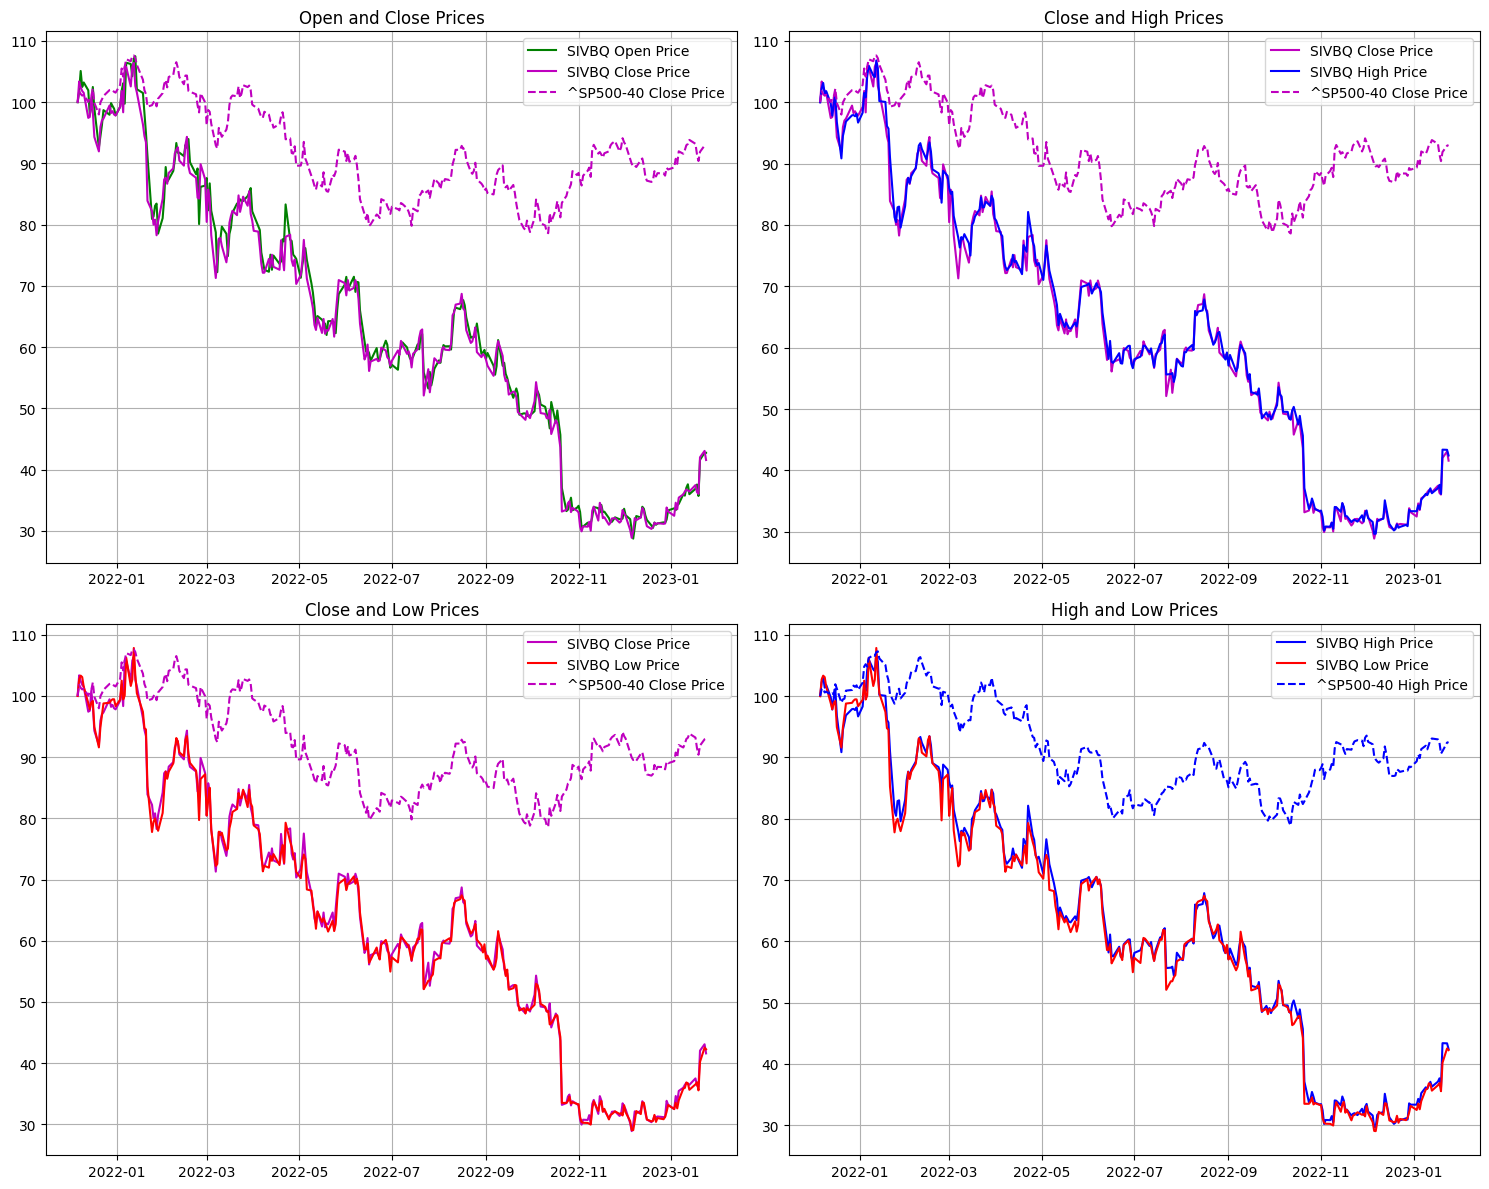

285
len datapoints in dataset 285 images generated 8
transformed_images.shape (8, 32, 32)
total chunks Open feature: 224
shape [0] set (1, 4, 224, 32, 32)
shape images array (1, 1, 4, 224, 32, 32) shape image (32, 32)


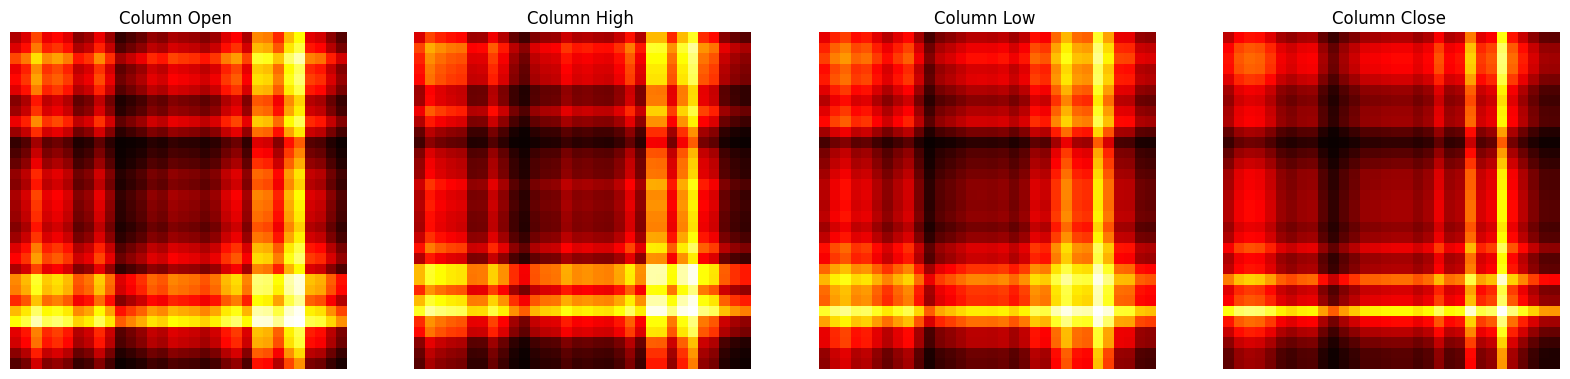

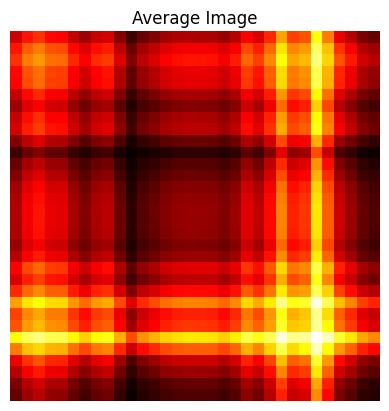

len img 4 image shape (4, 224, 32, 32)
len label 4 labels shape (4, 224)
Scaler received StandardScaler()
4D image array shape (4, 224, 32, 32)
3D reshaped image array  (896, 32, 32)
labels shape (896, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 0.5
len train 448 len test 448

Convos & dropoutP: 40 12 0
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
LeNet-5 Based Net: total params: 61257
conv1.weight: 240 weights
bn1.weight: 40 weights
conv2.weight: 2880 weights
bn2.weight: 12 weights
fc1.weight: 50400 weights
bn_fc1.weight: 100 weights
fc2.weight: 7000 weights
bn_fc2.weight: 70 weights
fc3.weight: 70 weights
Train params: learning_rate: 1e-05, momentum:0.9
epoch 0 data i 0 len image 16 shape torch.Size([16, 1, 32, 32])
epoch 0 data i 0 label tensor([[ 1.6660],
        [ 0.8787],
        [ 0.8787],
        [ 0.4779],
        [-0.4924],
        [-0.3088],
    

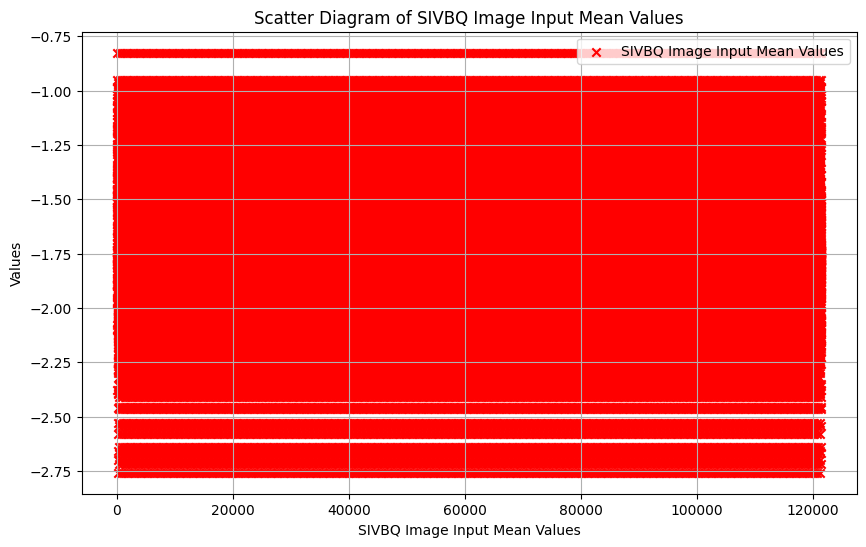

shape torch.Size([16, 1])
error_pct_outside_iqr 0.0
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([0.8929])%, Mean accuracy 1 decimal places: tensor([10.7143])%,
 Percentage of predictions within  2 decimal places: tensor([[3.5714],
        [0.0000],
        [3.5714],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000]])%, 1 decimal places: tensor([[14.2857],
        [10.7143],
        [10.7143],
        [ 3.5714],
        [10.7143],
        [14.2857],
        [17.8571],
        [14.2857],
        [10.7143],
        [ 3.5714],
        [10.7143],
        [ 7.1429],
        [17.8571],
        [10.7143],
        [ 3.5714],
        [10.7143]])%,



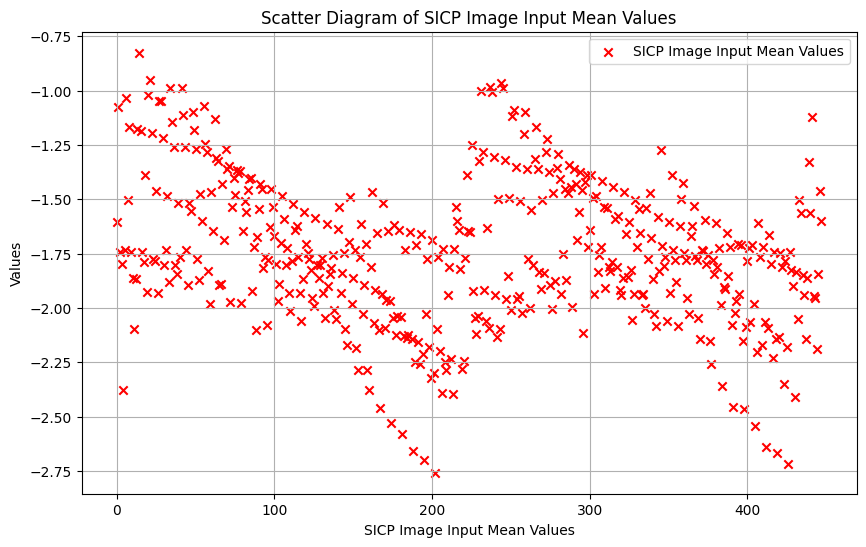

MAE: 0.5209816098213196

MSE: 0.40949201583862305

RMSE: 0.6399156451225281

MAPE: 620.2865600585938

R2: 0.5897135734558105



In [210]:
params = Parameters()
train_loader, test_loader = generate_dataset_to_images_process(params.train_stock_ticker, params)

net = train_process(train_loader, params)

test_process(net, test_loader, params)



# EXTERNAL MODEL VALIDATION

Inputs

In [211]:
# load model
PATH = f'./model_scen_{scenario}_full.pth'
net = helper_functions.Load_Full_Model(PATH)

#import stock dataset
stock_dataset_df = import_data.import_dataset(test_stock_ticker, start_date, end_date)

#Generate images from dataset
#cols_used = ["Open", "High", "Low", "Close"]
cols_used = ["Open", "High"]
cols_used_count = sum(column_name in cols_used for column_name in stock_dataset_df.columns)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_images.generate_multiple_feature_images(stock_dataset_df, cols_used, transform_algo, image_size=transformed_img_sz, method=gaf_method, sample_range=sample_range)
#print("image data",feature_image_dataset_list,"labels",feature_label_dataset_list)

#images to list and squeeze
images_array = helper_functions.data_to_array(feature_image_dataset_list)
labels_array = helper_functions.data_to_array(feature_label_dataset_list)
#squeeze arrays
images_array = images_array.squeeze(axis=(0, 1))
print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

#transform to tensor
feature_image_dataset_list_f32, labels_scaled_list_f32 = generate_images.Generate_feature_image_dataset_list_f32(labels_array, images_array, transformed_img_sz, scaler)

#generate data loaders
train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size)

#test and report
test_stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = Test(test_loader,net=net)



NameError: name 'scenario' is not defined

## CNN Validation with External Dataset

In [ ]:
importlib.reload(compute_stats)
importlib.reload(plot_data)

#load model
PATH = f'./model_scen_{0}_full.pth'
net = helper_functions.Load_Full_Model(PATH)

#import stock dataset
stock_dataset_df = import_data.import_dataset(test_stock_ticker, start_date, end_date)

#Generate images from dataset
#cols_used = ["Open", "High", "Low", "Close"]
cols_used = ["Open", "High"]
cols_used_count = sum(column_name in cols_used for column_name in stock_dataset_df.columns)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_images.generate_multiple_feature_images(stock_dataset_df, cols_used, transform_algo, image_size=transformed_img_sz, method=gaf_method, sample_range=sample_range)
#print("image data",feature_image_dataset_list,"labels",feature_label_dataset_list)

#images to list and squeeze
images_array = helper_functions.data_to_array(feature_image_dataset_list)
labels_array = helper_functions.data_to_array(feature_label_dataset_list)
#squeeze arrays
images_array = images_array.squeeze(axis=(0, 1))
print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

#transform to tensor
feature_image_dataset_list_f32, labels_scaled_list_f32 = generate_images.Generate_feature_image_dataset_list_f32(labels_array, images_array, transformed_img_sz, scaler)

#generate data loaders
train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size)

#test and report
test_stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = Test(test_loader,net=net)

[*********************100%%**********************]  1 of 1 completed

2.3.0+cu121
Loading Full Model
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
total chunks Open feature: 224
len img 2 image shape (2, 224, 32, 32)
len label 2 labels shape (2, 224)
Scaler received StandardScaler()
4D image array shape (2, 224, 32, 32)
3D reshaped image array  (448, 32, 32)
labels shape (448, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 1.0
len train 0 len test 448


shape torch.Size([16, 1])
error_pct_outside_iqr 0.0
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([1.1161])%, Mean accuracy 1 decimal places: tensor([10.2679])%,
 Percentage of predictions within  2 decimal places: tensor([[0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [3.5714],
        [3.5714],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000]])%, 1 decimal places: tensor([[10.7143],
        [ 7.1429],
        [ 3.5714],
        [10.7143],
        [ 7.1429],
        [ 7.1429],
        [ 3.5714],
        [10.7143],
        [21.4286],
        [ 3.5714],
        [10.7143],
        [17.8571],
        [14.2857],
        [10.7143],
        [ 7.1429],
        [17.8571]])%,



In [ ]:
# report stats results

#print("test_stack_input.shape",test_stack_input.shape,"test_stack input",test_stack_input)
#compute correl prices
compute_stats.stock_correlation_matrix(test_stock_ticker, stock_dataset_df)
#compute correl images
print("trained input image shape",stack_input.shape,"test input image shape",test_stack_input.shape)
image_series_correlations, image_series_mean_correlation = compute_stats.cross_stock_image_array_correlation2(test_stack_input,stack_input)

#compute cross correl
benchmark_stock_df = import_data.import_dataset(index_ticker, start_date, end_date)
compute_stats.cross_stock_df_correlation(test_stock_ticker,index_ticker,stock_dataset_df, benchmark_stock_df)

#compute stats
error_stats = compute_stats.compute_error_stats(stack_actual, stack_predicted)
print(f"Inference Model Stats for {test_stock_ticker}")
for key, value in error_stats.items():
    print(f'{key}: {value}')

Stock Correlation SICP
           Open     Close      High       Low
Open   1.000000  0.992518  0.997639  0.996629
Close  0.992518  1.000000  0.996566  0.997545
High   0.997639  0.996566  1.000000  0.997188
Low    0.996629  0.997545  0.997188  1.000000
trained input image shape torch.Size([28, 16, 1, 32, 32]) test input image shape torch.Size([28, 16, 1, 32, 32])


[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
Price Correlation between Open of SICP and SIVBQ: 0.9100
Price Correlation between Close of SICP and SIVBQ: 0.9089
Price Correlation between High of SICP and SIVBQ: 0.9113
Price Correlation between Low of SICP and SIVBQ: 0.9062
Inference Model Stats for SICP
MAE: 0.740517795085907
MSE: 0.8721766471862793
RMSE: 0.9339039921760559
MAPE: 166.49456787109375
R2: 0.1278233528137207


[*********************100%%**********************]  1 of 1 completed


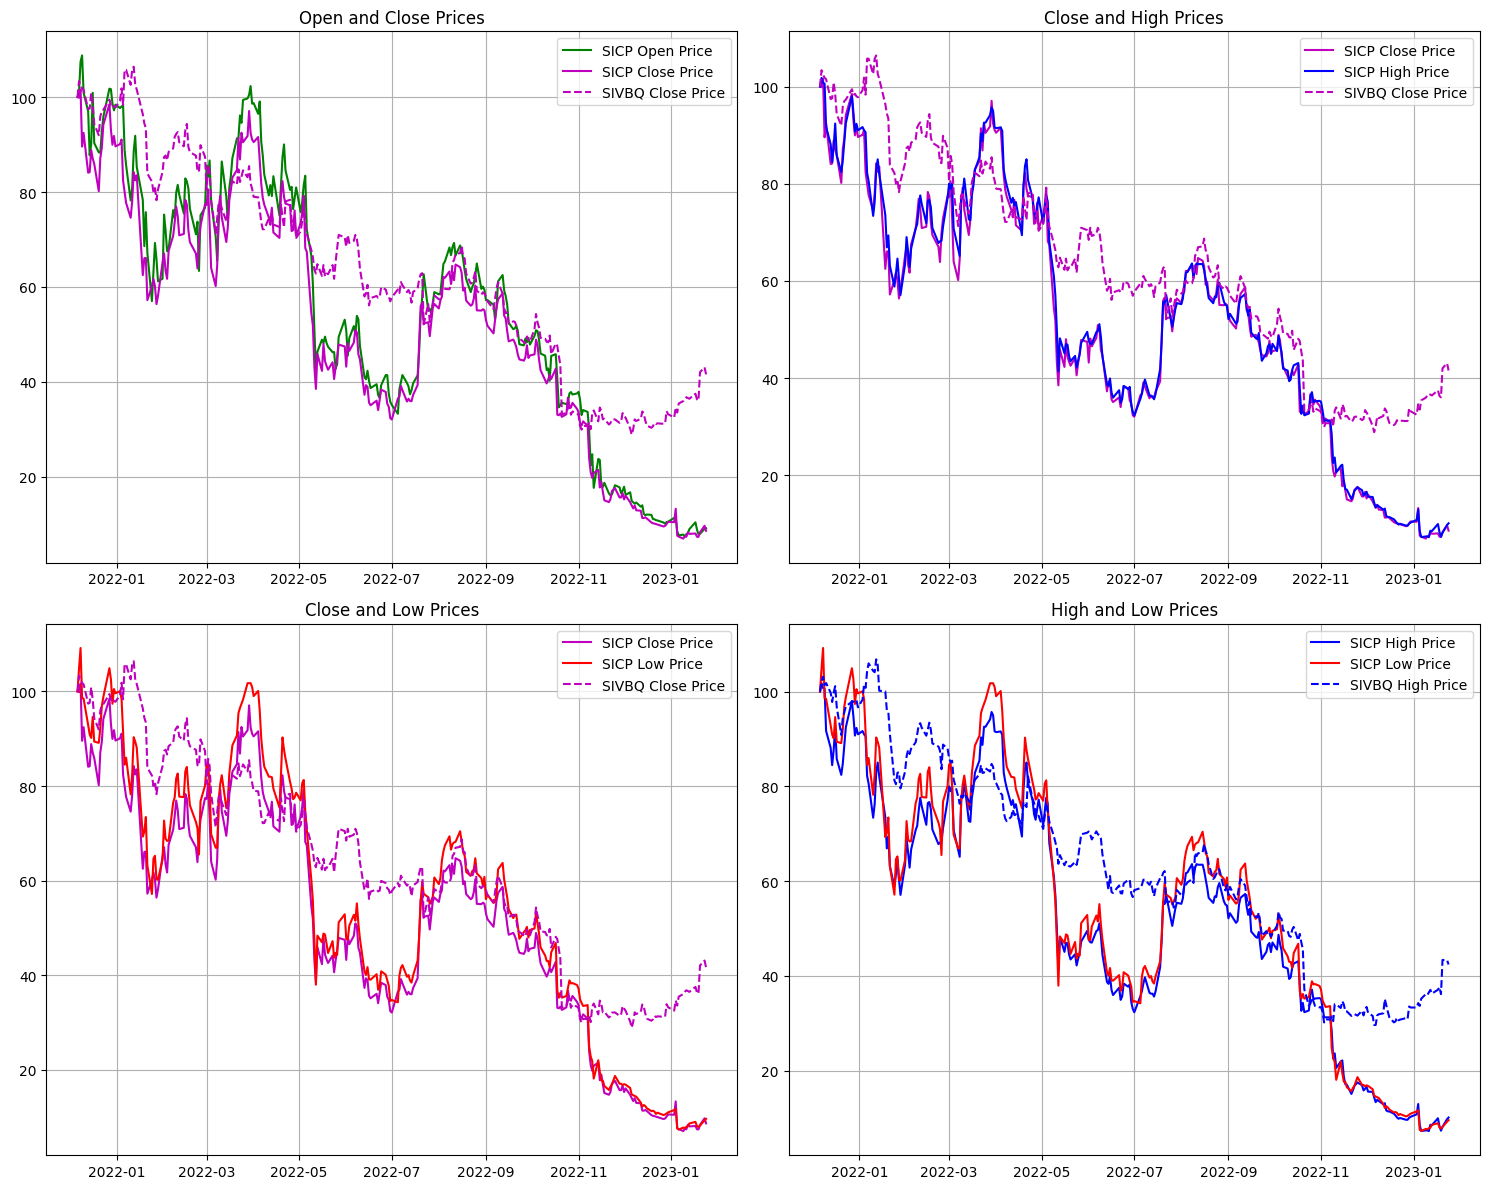

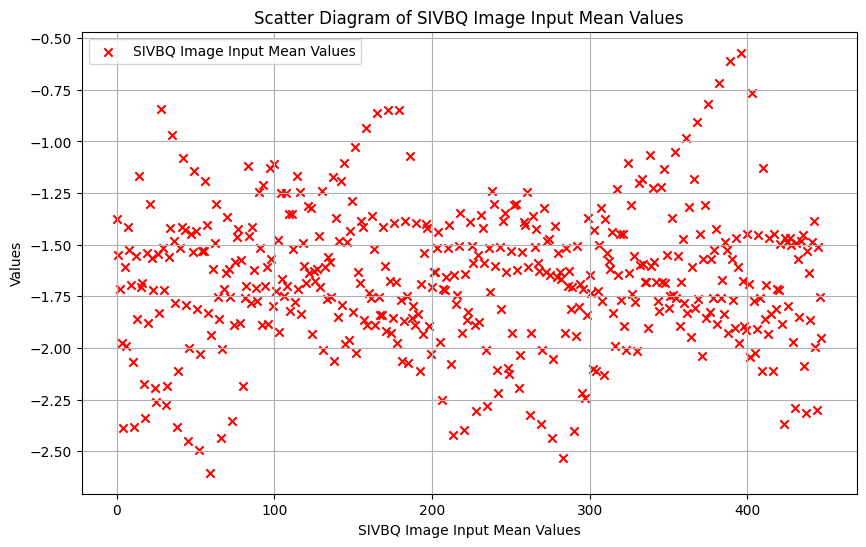

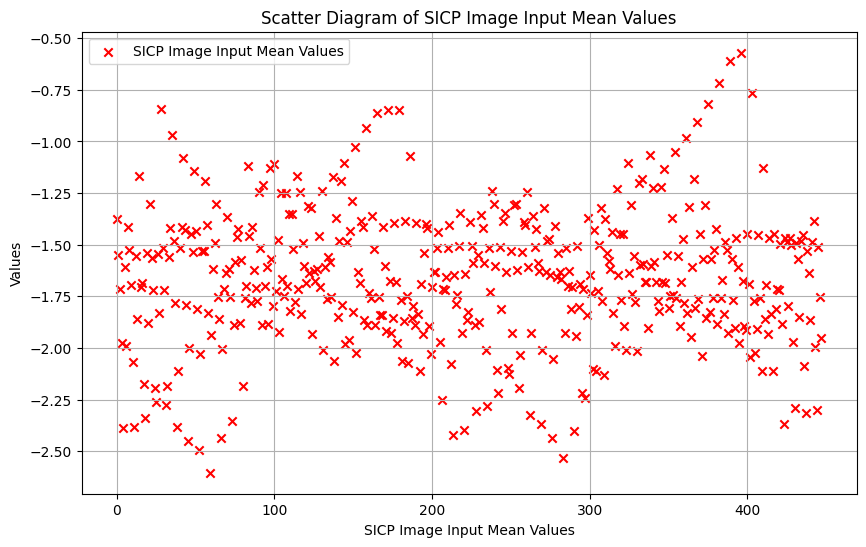

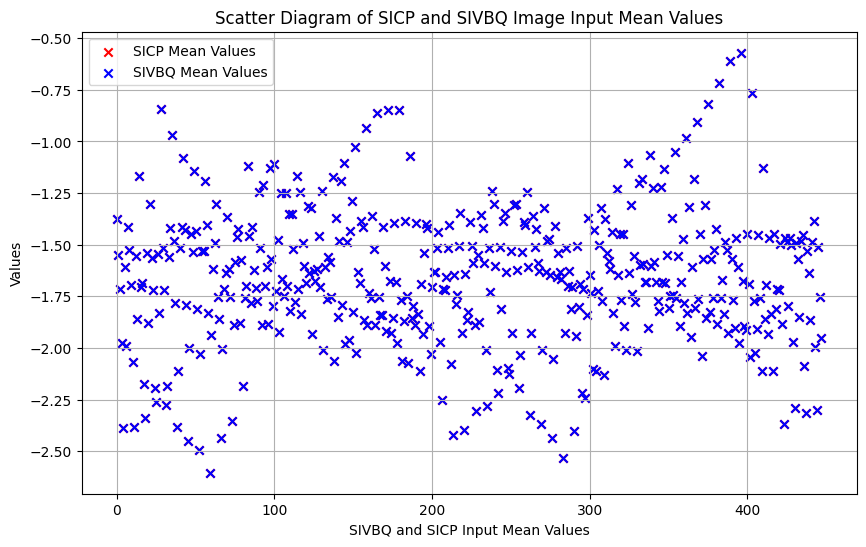

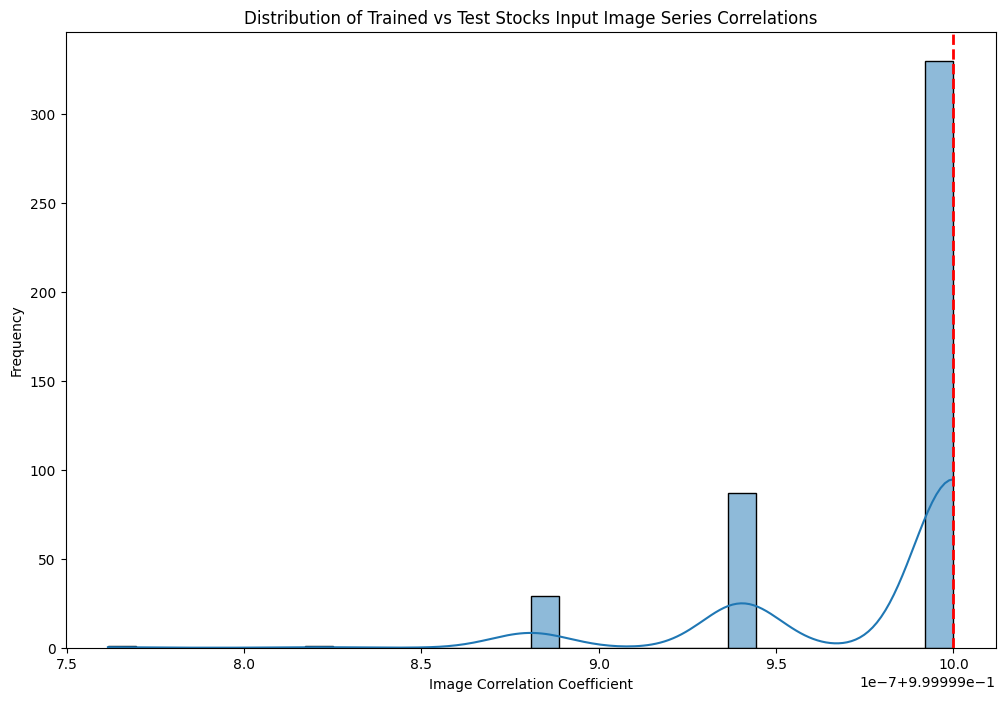

trained versus test stocks image series mean correlation 1.0


In [ ]:
#plot graphs

#plot data comparing stock prices
plot_data.compare_stocks(index_ticker,test_stock_ticker,stock_dataset_df, start_date, end_date)

#plot train stock mean inputs
plot_data.scatter_diagram_onevar_plot_mean(stack_input, train_stock_ticker)

#plot predicted stock mean inputs
plot_data.scatter_diagram_onevar_plot_mean(test_stack_input, test_stock_ticker)

#scatter actual vs predicted
plot_data.scatter_diagram_twovar_plot_mean(test_stock_ticker,train_stock_ticker,test_stack_input, stack_input)

#plot trained versus test stocks image series mean correlations
plot_data.plot_image_correlations(image_series_correlations, image_series_mean_correlation)
print("trained versus test stocks image series mean correlation",image_series_mean_correlation)

## Bayesian Optimization for CNN Hyperparameters

In [ ]:
def CNN_Optimization(output_conv_1, 
                     output_conv_2,
                     dropout_probab,
                     learning_rate,
                     momentum,
                     train_loader,test_loader,
                     iteration=None):
    
    output_conv_1 = int(output_conv_1)
    output_conv_2 = int(output_conv_2)
    
    net = Net(output_conv_1=output_conv_1, output_conv_2=output_conv_2,dropout_probab=dropout_probab)
    net.to(device)

    Train(learning_rate=learning_rate, train_loader=train_loader, net=net, momentum=momentum)

    if iteration is not None:
        helper_functions.Save_BayesOpt_Model(iteration,net)

    stack_input, predicted, actual, accuracy, percentage_diffs, mean_percentage_diff = Test(test_loader=test_loader,net=net)
    
    print("accuracy received",accuracy)

    return accuracy

In [ ]:
def Optimize():
    
    train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size, train_shuffle=False)
    
    iteration_counter = [0]

    def cnn_correct_pct_wrapper(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum):
        result = CNN_Optimization(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum, train_loader, test_loader, iteration=iteration_counter[0])
        iteration_counter[0] += 1
        return result
    #cnn_correct_pct = partial(CNN_Optimization, train_loader = train_loader, test_loader = test_loader)

    # Bounded region of parameter space
    pbounds = {'output_conv_1': (40, 80),
               'output_conv_2': (8, 16), 
               'learning_rate': (0.00001, 0.0001), 
               'dropout_probab': (0.0, 0.5), 
               'momentum': (0.8, 1.0)}

    optimizer = BayesianOptimization(
        f = cnn_correct_pct_wrapper,
        pbounds=pbounds,
        random_state=1,
        )

    #n_iter:steps of bayesian optimization you want to perform
    #init_points:steps of random exploration
    optimizer.maximize(init_points=10, n_iter=10,)

    with open(f'optimizer_results.txt', 'a') as file:
        for i, res in enumerate(optimizer.res):
            print(f"Iteration {i}: \n\t{res}")
            file.write("\n\nIteration {}: \n\t{}".format(i, res))

    optimizer_max_result = optimizer.max
    print("optimizer result:\n",optimizer.max)

    with open(f'optimizer_results.txt', 'a') as file:
        file.write('\noptimizer results:\n' + str(optimizer_max_result))

In [ ]:
# comment out to not run bayesian opt
#Optimize()

In [ ]:
# example to reconstruct Net model design. Enter optimizer_results.txt scenario variable results used to validate the net design model inference result matches the optimizer_results.txt output
# dropout_probab = 0.4473033317519236
# learning_rate = 1.7653979023280013e-05
# momentum = 0.8078109566465765
# output_conv_1 = int(46.7)
# output_conv_2 = int(15.0)

# net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
#             filter_size_3=filter_size_3, stride=stride,
#             image_resolution_x=32,image_resolution_y=32,
#             output_conv_1=output_conv_1, output_conv_2=output_conv_2,
#             output_FC_1=output_FC_1, output_FC_2=output_FC_2,
#             final_FCLayer_outputs=final_FCLayer_output,
#             dropout_probab=dropout_probab)

# net.to(device)
# net.parameters()

# net = Load_BayesOpt_Model("5",net)

# predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df = Test_And_Report(net)
